## Installs (optional)

In [ ]:
%pip install numpy matplotlib ipywidgets pillow

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation, ArtistAnimation
from IPython.display import HTML, display
from matplotlib.animation import PillowWriter

%matplotlib widget

### Simulation Parameters

**Warning: takes ±30 minutes to compute to submission-standard. Set frames and field size lower for a quick review**

In [101]:

nx, ny   = 200,200              # grid width (x), height (y)
p        = 0.02                 # prob EMPTY -> TREE per step
f        = 0.0001              # prob TREE -> FIRE by lightning per step
tree_init_density = 0.1         # initial tree fraction
fire_init_density = 0.01        # initial fire fraction
timesteps    = 25000       
seed     = 42
border   = 1                    # empty border thickness
cmap = ListedColormap([(0.2,0,0), (0,0.5,0), (1,0,0)])  # colormap for plots. empty=darkbrown, tree=green, fire=red

### Initialization of the grid and simulation variables

In [107]:
random_generator = np.random.default_rng(seed) #starting a random number generator with the seed set

neighbour_deltas = ((-1,-1),(-1,0),(-1,1),( 0,-1),( 0, 1),( 1,-1), ( 1,0), ( 1,1)) # relative index deltas for neighbouring cells

EMPTY, TREE, FIRE = 0, 1, 2 # Defining proxies for the numerical representations of the cell types, for readability

# function to set an empty grid with sets at each cell, in order to hold the IDs of identified fires
def empty_id_grid(shape):
    a = np.empty(shape, dtype=object)
    for i in range(shape[0]):
        for j in range(shape[1]):
            a[i, j] = set()
    return a

# Initalize the main grid
grid = np.zeros((ny, nx), dtype=np.int8)

# start with the requisite tree density
grid[random_generator.random((ny, nx)) < tree_init_density] = TREE

# start with the requisite fire density
grid[random_generator.random((ny, nx)) < fire_init_density] = FIRE

# enforce empty border at the start to prevent wraparound
grid[:border, :] = EMPTY
grid[-border:, :] = EMPTY
grid[:, :border] = EMPTY
grid[:, -border:] = EMPTY

# initialize variable for grid history
grid_history = []

# initialize variables for cell type counts
fire_count  = np.zeros(timesteps, dtype=int)
tree_count  = np.zeros(timesteps, dtype=int)
empty_count = np.zeros(timesteps, dtype=int)

# initialize variables for counting the transitions per step
n_tree_to_fire  = np.zeros(timesteps, dtype=int)
n_empty_to_tree = np.zeros(timesteps, dtype=int)
n_fire_to_empty = np.zeros(timesteps, dtype=int)

# initialize the ID grid (for fire ID propagations) using our helper
id_grid = empty_id_grid(grid.shape)
fire_id = 1

# initialize per ID stats - FIX
id_origin      = {}  # id -> (y0, x0)
id_duration    = {}  # id -> frames present anywhere

### Main Updates Loop

In [ ]:
for t in range(timesteps):
    # add current grid to the history for animation later
    grid_history.append(grid.copy())

    # Masks for cell types
    fires  = (grid == FIRE)
    trees  = (grid == TREE)
    empties = (grid == EMPTY)

    # calculate which areas have fires nearby
    neighbours_fire = np.zeros_like(fires, dtype=bool)
    for dy, dx in neighbour_deltas:
        y0 = max(0, -dy); y1 = min(ny, ny - dy)
        x0 = max(0, -dx); x1 = min(nx, nx - dx)
        neighbours_fire[y0:y1, x0:x1] |= fires[y0+dy:y1+dy, x0+dx:x1+dx]

    # lightning strikes
    lightning = trees & (random_generator.random(grid.shape) < f)

    # trees that will burn by fire_spread
    burn_by_fire_spread = trees & neighbours_fire

    # total of trees that will burn
    will_burn = lightning | burn_by_fire_spread  #either lightning strikes, or neighbours a fire
    
    # trees that will grow (randomly generated according to parameter)
    will_grow = empties & (random_generator.random(grid.shape) < p)

    # generate the next grid step
    grid_next = np.full_like(grid, EMPTY, dtype=np.int8)
    grid_next[will_grow] = TREE
    grid_next[will_burn] = FIRE
    grid_next[fires] = EMPTY

    # cells that will not burn, won't grow, and don't currently have a fire will retain their state
    stay = ~(will_grow | will_burn | fires) 
    grid_next[stay] = grid[stay]

    # zero out the next id grid
    id_grid_next = empty_id_grid(grid.shape)

    # assign fresh IDs to lightning cells
    ly_coords = np.argwhere(lightning) #get coordinates of lightning
    for fire_id, (y, x) in enumerate(ly_coords, start=fire_id):
        id_grid_next[y, x].add(fire_id)
        id_duration[fire_id] = 0
    fire_id += ly_coords.shape[0] #these many IDs have been now assigned, so skip ahead

    # propagate neighbor IDs for neighbours of fire
    for (y, x) in np.argwhere(burn_by_fire_spread):
        ids_here = set()
        for dy, dx in neighbour_deltas:
            y2, x2 = y + dy, x + dx
            if 0 <= y2 < ny and 0 <= x2 < nx and fires[y2, x2]:
                if id_grid[y2, x2]:
                    ids_here |= id_grid[y2, x2]
        if ids_here:
            id_grid_next[y, x] |= ids_here

    # unioning all id's in all id sets in the grid (id_grid), so we can check if the fire ID is still present or not
    active_ids_this_frame = set().union(*(id_grid_next[y, x] for y, x in np.argwhere(grid_next == FIRE)))

    # increment for each fire id still active this frame
    for fire_id in active_ids_this_frame: id_duration[fire_id] += 1

    # calculate metrics - counts
    fire_count[t]  = int(fires.sum())
    tree_count[t]  = int(trees.sum())
    empty_count[t] = int(empties.sum())

    # calculate metrics - transformations
    n_tree_to_fire[t]  = int(will_burn.sum())
    n_empty_to_tree[t] = int(will_grow.sum())
    n_fire_to_empty[t] = int(fires.sum()) # we can use fires because it will be empty next timestep

    # enforce empty borders before updating grid
    if border > 0:
        grid_next[:border, :] = EMPTY; grid_next[-border:, :] = EMPTY
        grid_next[:, :border] = EMPTY; grid_next[:, -border:] = EMPTY
        for x in range(nx):
            id_grid_next[0, x].clear()
            id_grid_next[ny-1, x].clear()
        for y in range(ny):
            id_grid_next[y, 0].clear()
            id_grid_next[y, nx-1].clear()

    # advance time step - replace both grids with updated versions
    grid    = grid_next
    id_grid = id_grid_next

# postprocess durations for plotting the distribution
durations = np.array(list(id_duration.values()))

print(f"Simulation Complete. Recorded {len(durations)} fires")


### PLOT: Final Grid (Preview)

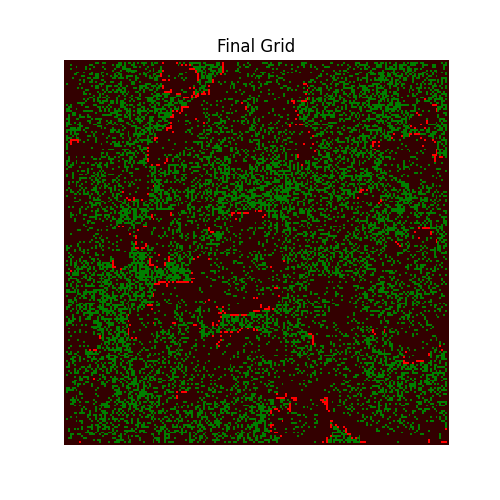

In [104]:
plt.figure(figsize=(5,5))
plt.imshow(grid, vmin=0, vmax=2, interpolation="nearest", cmap=cmap)
plt.title("Final Grid")
plt.axis("off")
plt.show()

### PLOT: Evolution of counts over time, with means

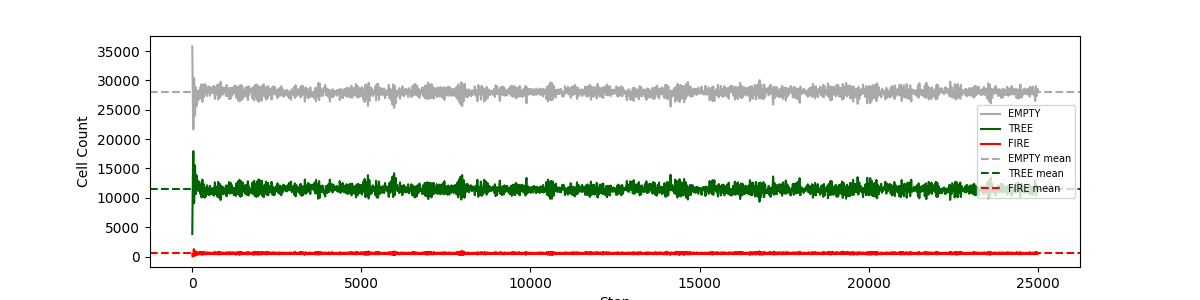

In [105]:
plt.figure(figsize=(12,3))

# Plot the main counts
plt.plot(empty_count, color = "darkgrey", label="EMPTY")
plt.plot(tree_count, color = "darkgreen",  label="TREE")
plt.plot(fire_count,  color = "red", label="FIRE")

#Plot the means
plt.axhline(empty_count.mean(), ls="--", color = "darkgrey", label=f"EMPTY mean")
plt.axhline(tree_count.mean(),  ls="--", color = "darkgreen", label=f"TREE mean")
plt.axhline(fire_count.mean(),  ls="--", color = "red", label=f"FIRE mean")

#Titles, legends and other plot adjustments
plt.xlabel("Step")
plt.ylabel("Cell Count")
plt.legend(fontsize=7)
plt.show()

### PLOT: Fire durations and their probability

Estimated power-law exponent α ≈ 1.169


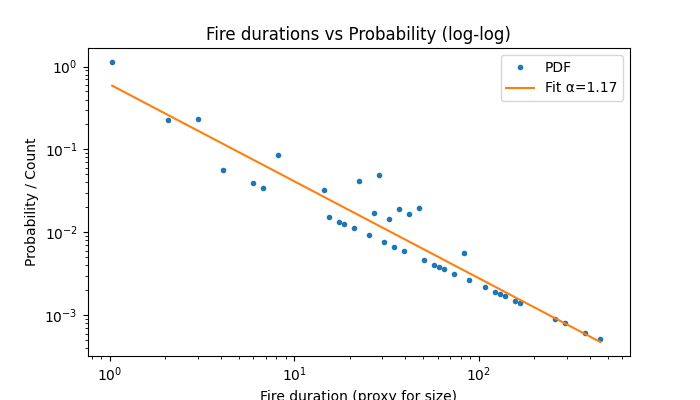

In [ ]:
durations = durations[durations > 0]

plt.figure(figsize=(7,4))
bins = np.logspace(np.log10(durations.min()), np.log10(durations.max()), 100)
counts, edges = np.histogram(durations, bins=bins, density=True)
centers = np.sqrt(edges[:-1] * edges[1:])

mask = counts > 0
logx = np.log10(centers[mask])
logy = np.log10(counts[mask])
slope, intercept = np.polyfit(logx, logy, 1)
alpha = -slope
print(f"Estimated power-law exponent α ≈ {alpha:.3f}")

plt.loglog(centers, counts, '.', label='PDF')
plt.loglog(centers[mask], 10**(intercept + slope*logx), '-', label=f'Fit α={alpha:.2f}')
plt.xlabel("Fire duration (proxy for size)")
plt.ylabel("Probability / Count")
plt.title("Fire durations vs Probability (log-log)")
plt.legend()
plt.show()

### OPTIONAL: Animation export

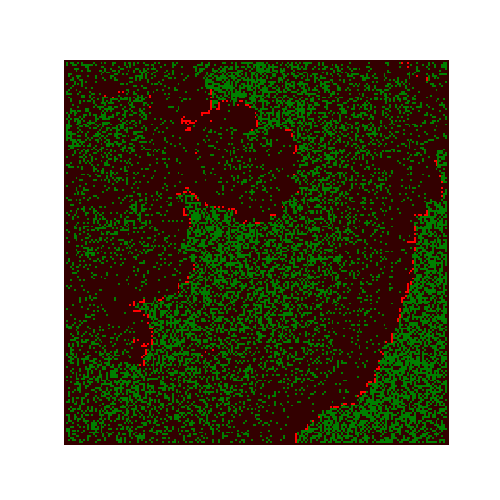

In [73]:
fig, ax = plt.subplots(figsize=(5,5))
ax.axis("off")

ims = []
for frame in grid_history:                      # its 2D arrays recording frames
    im = ax.imshow(frame, vmin=0, vmax=2, cmap=cmap, animated=True, interpolation="nearest")
    ims.append([im])

ani = ArtistAnimation(fig, ims, interval=30, blit=True, repeat=True)
ani.save("forest_fire_RENDER.gif", writer=PillowWriter(fps=60))
plt.show()